In [43]:
import pandas as pd
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,MultiComparison)
import matplotlib.pyplot as plt
import numpy as np
from factor_analyzer import FactorAnalyzer

In [15]:
rpe_file = '~/Desktop/rpe.csv'
rpe_data = pd.read_csv(rpe_file)
rpe_data.shape


(8860, 14)

In [16]:
print(list(rpe_data.columns))

['Date', 'PlayerID', 'Training', 'SessionType', 'Duration', 'RPE', 'SessionLoad', 'DailyLoad', 'AcuteLoad', 'ChronicLoad', 'AcuteChronicRatio', 'ObjectiveRating', 'FocusRating', 'BestOutOfMyself']


In [22]:
rpe_data = rpe_data.dropna(subset=['RPE'])
rpe_data = rpe_data.dropna(subset=['SessionType'])
rpe_data = rpe_data.dropna(subset=['AcuteChronicRatio'])
rpe_data = rpe_data.dropna(subset=['Duration'])
rpe_data.shape


(3149, 14)

In [18]:
rpe_data.head()


,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself
0,2018-07-21,13,Yes,Mobility/Recovery,5.0,0.0,0.0,446.0,323.1,303.25,1.07,NaN,NaN,Not at all
3,2018-07-20,11,Yes,Game,36.0,6.0,216.0,534.0,256.3,344.18,0.74,9.0,10.0,Absolutely
6,2018-07-20,13,Yes,Game,27.0,6.0,162.0,306.0,259.4,287.32,0.90,NaN,NaN,Not at all
9,2018-07-19,1,Yes,Skills,60.0,3.0,180.0,180.0,87.9,140.54,0.63,NaN,NaN,NaN
10,2018-07-19,2,Yes,Skills,60.0,4.0,240.0,240.0,117.1,279.96,0.42,NaN,NaN,NaN


In [19]:
rpe_data.groupby(rpe_data["SessionType"])["SessionType"].count()


SessionType
Conditioning          454
Game                  142
Mobility/Recovery     427
Skills                630
Speed                1199
Strength              297
Name: SessionType, dtype: int64

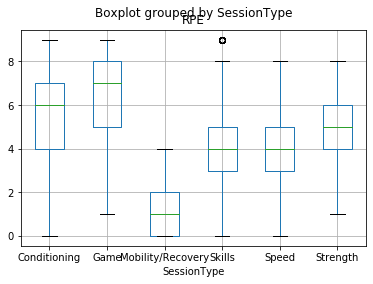

In [21]:
rpe_data.boxplot(column = 'RPE',by = 'SessionType')


In [33]:
pairwise_tukeyhsd(rpe_data["RPE"],rpe_data["SessionType"]).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Combat,Conditioning,2.1053,0.001,1.7308,2.4799,True
Combat,Game,2.0734,0.001,1.6666,2.4803,True
Combat,Mobility/Recovery,-3.1398,0.001,-3.5134,-2.7663,True
Combat,Skills,-0.1147,0.9,-0.4737,0.2444,False
Combat,Speed,-0.1785,0.7567,-0.5458,0.1888,False
Combat,Strength,0.8609,0.001,0.5023,1.2196,True
Conditioning,Game,-0.0319,0.9,-0.3006,0.2368,False
Conditioning,Mobility/Recovery,-5.2452,0.001,-5.4601,-5.0302,True
Conditioning,Skills,-2.22,0.001,-2.4087,-2.0313,True
Conditioning,Speed,-2.2839,0.001,-2.4878,-2.0799,True


Since most of groups have different mean for RPE, we can include that SessionType is highly correlated to RPE

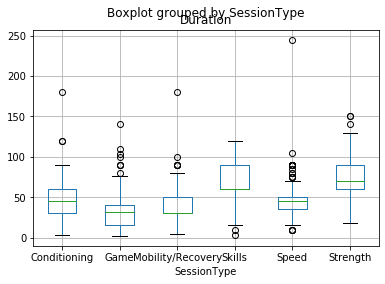

In [23]:
rpe_data.boxplot(column = 'Duration',by = 'SessionType')

In [24]:
pairwise_tukeyhsd(rpe_data["Duration"],rpe_data["SessionType"]).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Conditioning,Game,-15.5706,0.001,-20.6103,-10.5308,True
Conditioning,Mobility/Recovery,-8.5029,0.001,-12.0364,-4.9694,True
Conditioning,Skills,15.2698,0.001,12.043,18.4966,True
Conditioning,Speed,-4.6303,0.001,-7.5187,-1.7419,True
Conditioning,Strength,26.2295,0.001,22.3178,30.1413,True
Game,Mobility/Recovery,7.0677,0.001,1.9901,12.1452,True
Game,Skills,30.8404,0.001,25.9713,35.7095,True
Game,Speed,10.9402,0.001,6.2885,15.592,True
Game,Strength,41.8001,0.001,36.4524,47.1478,True
Mobility/Recovery,Skills,23.7727,0.001,20.4872,27.0583,True


In [27]:

conditions = [
    (rpe_data['AcuteChronicRatio'] <= 0.8),
    (rpe_data['AcuteChronicRatio'] > 0.8) & (rpe_data['AcuteChronicRatio'] < 1.2),
    (rpe_data['AcuteChronicRatio'] >=1.2)]
choices = ['recovering', 'normal', 'high']
rpe_data["Load Status"] = np.select(conditions,choices)

In [32]:
rpe_data.groupby(rpe_data["Load Status"])["Load Status"].count()


Load Status
high           988
normal        1002
recovering    1159
Name: Load Status, dtype: int64

In [53]:
rpe_data.head()
df = rpe_data[["SessionType","Duration","RPE","AcuteChronicRatio","Load Status"]]
df.dropna()
df.shape
df["status_factor"] = pd.factorize(df["Load Status"])[0]
df["type_factor"] = pd.factorize(df["SessionType"])[0]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [62]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df)
chi_square_value, p_value

(1473.0528478720091, 1.0317176580752682e-299)

In this Bartlett ’s test, the p-value is $1.0317176580752682\times 10^{-299}$. The test was statistically significant, indicating that the observed correlation matrix is not an identity matrix.

In [63]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model= calculate_kmo(df[["type_factor","Duration","RPE","AcuteChronicRatio","status_factor"]])
kmo_model

0.5574032410631249

But in KMO test, it determines the adequacy for each observed variable and for the complete model. But our value is smaller than 0.6, which suggest inadequacy.

In [64]:
# Create factor analysis object and perform factor analysis

fa = FactorAnalyzer()
fa.analyze(df, 5, rotation=None)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

,Original_Eigenvalues
0,1.698833
1,1.284132
2,0.846663
3,0.644495
4,0.525877


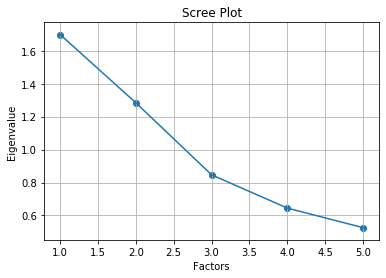

In [66]:
plt.scatter(range(1,5+1),ev)
plt.plot(range(1,5+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [67]:
fa = FactorAnalyzer()
fa.analyze(df, 2, rotation="varimax")
fa.loadings

,Factor1,Factor2
Duration,0.068676,0.354276
RPE,0.000546,0.778266
AcuteChronicRatio,0.994290,0.080418
status_factor,0.458746,0.095161
type_factor,0.093725,0.425290


In [68]:
fa.get_factor_variance()

,Factor1,Factor2
SS Loadings,1.212562,0.927604
Proportion Var,0.242512,0.185521
Cumulative Var,0.242512,0.428033


In [71]:
#Load Status
#high           988
#normal        1002
#recovering    1159
[p1,p2,p3]=[998,1002,1159]/np.sum([998,1002,1159]) 
conditions = [
    (rpe_data['Load Status'] == "high"),
    (rpe_data['Load Status'] == "normal"),
    (rpe_data['Load Status'] == "recovering")]
choices = [p1, p2, p3]
df["status_porpotion"] = np.select(conditions,choices)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [73]:
#Conditioning          454
#Game                  142
#Mobility/Recovery     427
#Skills                630
#Speed                1199
#Strength              297
[p1,p2,p3,p4,p5,p6]=[454,142,427,630,1199,297]/np.sum([454,142,427,630,1199,297]) 
conditions = [
    (rpe_data["SessionType"] == "Conditioning"),
    (rpe_data["SessionType"] == "Game"),
    (rpe_data["SessionType"] == "Mobility/Recovery"),
    (rpe_data["SessionType"] == "Skills"),
    (rpe_data["SessionType"] == "Speed"),
    (rpe_data["SessionType"] == "Strength")
]
choices = [p1,p2,p3,p4,p5,p6]
df["type_porpotion"] = np.select(conditions,choices)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [74]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model= calculate_kmo(df[["RPE","type_porpotion","Duration","AcuteChronicRatio","status_porpotion"]])
kmo_model

0.5288001777017137

In [75]:
df[["RPE","type_porpotion","Duration","AcuteChronicRatio","status_porpotion"]].cov()

,RPE,type_porpotion,Duration,AcuteChronicRatio,status_porpotion
RPE,4.340500,-0.019541,12.487731,0.090779,-0.003319
type_porpotion,-0.019541,0.014360,-0.464127,0.007733,-0.000410
Duration,12.487731,-0.464127,474.192978,1.411572,-0.034268
AcuteChronicRatio,0.090779,0.007733,1.411572,0.477481,-0.009952
status_porpotion,-0.003319,-0.000410,-0.034268,-0.009952,0.000590


In [87]:
new_df = df[["RPE","type_factor","Duration","status_factor"]]

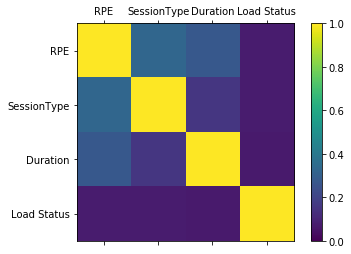

In [88]:
correlations = new_df.corr()
# plot correlation matrix
names = ["RPE","SessionType","Duration","Load Status"]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-0, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,4,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [89]:
df["RPE"].standardize()

AttributeError: 'Series' object has no attribute 'standardize'

In [ ]:
df["RPE"].plot(kind='bar')
plt.show()

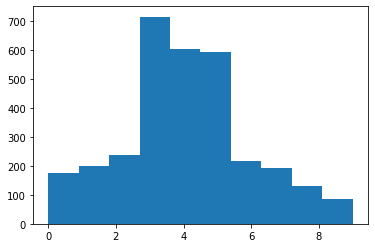

In [99]:
a = plt.hist(df["RPE"],bins = 10)
plt.show()

In [110]:
from sklearn import preprocessing
# Get column names first
names = df.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object


ValueError: could not convert string to float: 'Mobility/Recovery'

array([[0.        , 0.02362113, 0.02362113, ..., 0.00787371, 0.01968428,
        0.00787371]])

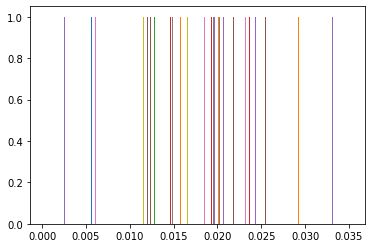